In [16]:
# Importing required libraries
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import integrate
import seaborn as sns

import bisect

# Ensure results directory exists
os.makedirs('results', exist_ok=True)

# Define the number of bins for the histogram
num_bins = 100

# Define a color-palette to use.
# For example colorblind from seaborn
color_palette = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC",
            "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9",
            "#8B0000", "#FF6347"]

In [2]:
# Define the path to the root directory of the data
root_path = "./data/sampling/"

# Define the suffixes for the sample size files
sample_size_suffix_rq1 = "t2"
sample_size_suffix_rq2 = "sampleSize_300"
sample_size_suffix_discussion = "sampleSize_2100"

# Define the sampling strategies to use
sampling_strategies = [
    ('random', ';', color_palette[0], 'Uniform Random'),
    ('divDistBased', ';', color_palette[1], 'Distance-based'),
    ('solverBased', ';', color_palette[2], 'Solver-based'),
    ('SRSSampling', ',', color_palette[3], 'Statistical Recursive Search'),
    ('baital_s1', ';', color_palette[4], 'BAITAL (s=1)'),
    ('baital_s2', ';', color_palette[5], 'BAITAL (s=2)'),
    ('baital_s3', ';', color_palette[6], 'BAITAL (s=3)'),
    ('baital_s4', ';', color_palette[7], 'BAITAL (s=4)'),
    ('baital_s5', ';', color_palette[8], 'BAITAL (s=5)'),
    ('henard', ';', color_palette[9], 'Henard'),
    ('grammarBased', ';', color_palette[10], 'Grammar-based'),
    ]

# Number of sample sets per system and sampling strategy
number_of_sample_sets = 100

# configurable system names
cs_information = [
    ("7z", "Performance", "7z (Performance, t2)"),
    ("BerkeleyDBC", "Performance", "Berkeley DB (Performance, t2)"),
    ("Dune", "Performance", "Dune (Performance, t2)"),
    ("Hipacc", "Performance", "Hipacc (Performance, t2)"),
    ("JavaGC", "Performance", "Java GC (Performance, t2)"),
    ("LLVM", "Performance", "LLVM (Performance, t2)"),
    ("Polly", "Performance", "Polly (Performance, t2)"),
]

In [3]:
def estimate_epsilon(data, max):
    """
    Estimate the (posterior) probability of finding a value greater than max in the data.
    """
    return sum(i > max for i in data) / data.size

def estimate_epsilon_from_sorted(data, max):
    """
    Estimate the (posterior) probability of finding a value greater than max in the **sorted** data.
    """
    n = bisect.bisect_right(data, max)
    return (data.size - n) / data.size

def calculate_prior_beta(epsilon, sample_count):
    """
    Estimate the confidence in the estimate of epsilon given the number of samples.
    """
    return (1 - epsilon) ** (sample_count + 1)

def calculate_beta(epsilon, sample_count):
    """
    Estimate the confidence in the estimate of (posterior) epsilon given the number of samples.
    """
    if (epsilon == 0):
        return 0
    else:
        return (1 - epsilon) ** (sample_count + 1)

def ecdf(epsilon_values):
    """
    Compute the empirical cumulative distribution function of the epsilon values.
    Returns the sorted epsilon values and the corresponding cumulative probabilities.
    """
    epsilon_values_sorted = np.sort(epsilon_values)
    n = epsilon_values.size
    return epsilon_values_sorted, np.arange(1, n + 1) / n

def __get_y_value(x_values, y_values, step):
    """
    Get the y value for a given value (step) from an empirical cumulative distribution function.
    """
    n = bisect.bisect_left(x_values, step)
    return y_values[n - 1] if n > 0 else 0

def get_y_values(x_values, y_values, steps):
    """
    Get all y values for a given set of values (steps) from an empirical cumulative distribution function.
    """
    return [__get_y_value(x_values, y_values, step) for step in steps]

<>:91: SyntaxWarning: invalid escape sequence '\h'
<>:103: SyntaxWarning: invalid escape sequence '\h'
<>:139: SyntaxWarning: invalid escape sequence '\h'
<>:143: SyntaxWarning: invalid escape sequence '\h'
<>:91: SyntaxWarning: invalid escape sequence '\h'
<>:103: SyntaxWarning: invalid escape sequence '\h'
<>:139: SyntaxWarning: invalid escape sequence '\h'
<>:143: SyntaxWarning: invalid escape sequence '\h'
/var/folders/hj/x93rqrkn5zx8g7nx4gdjjp0r0000gn/T/ipykernel_38759/3654486745.py:91: SyntaxWarning: invalid escape sequence '\h'
  ax.text(epsilon_t2_wise, y_bottom + 0.02, '2-wise ($\hat{\epsilon}$)', color='blue', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
/var/folders/hj/x93rqrkn5zx8g7nx4gdjjp0r0000gn/T/ipykernel_38759/3654486745.py:103: SyntaxWarning: invalid escape sequence '\h'
  ax.text(epsilon_t3_wise, y_bottom + 0.05, '3-wise ($\hat{\epsilon}$)', color='red', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
/var/folders/hj/x93r

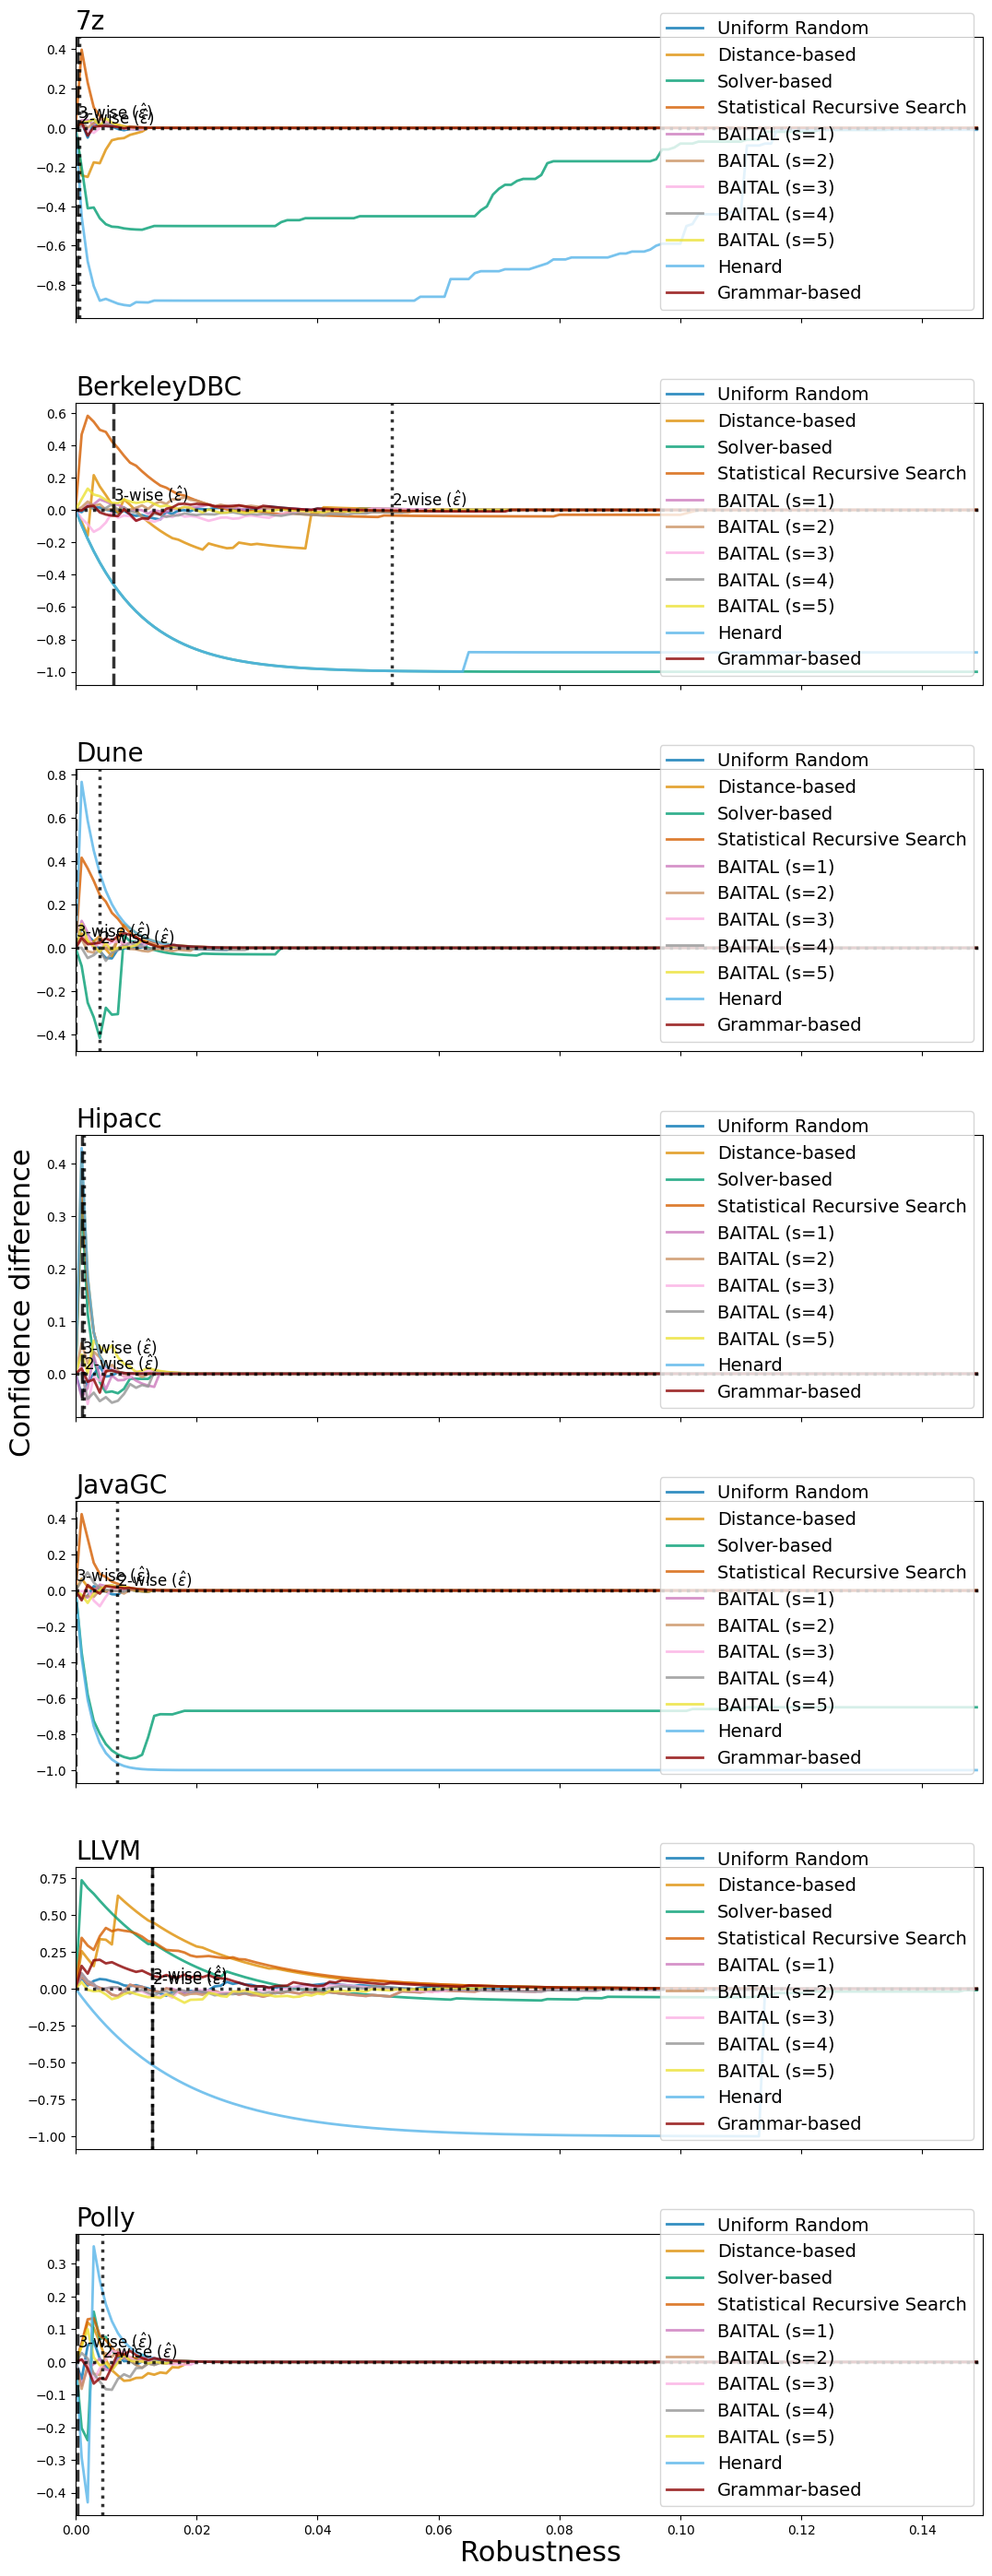

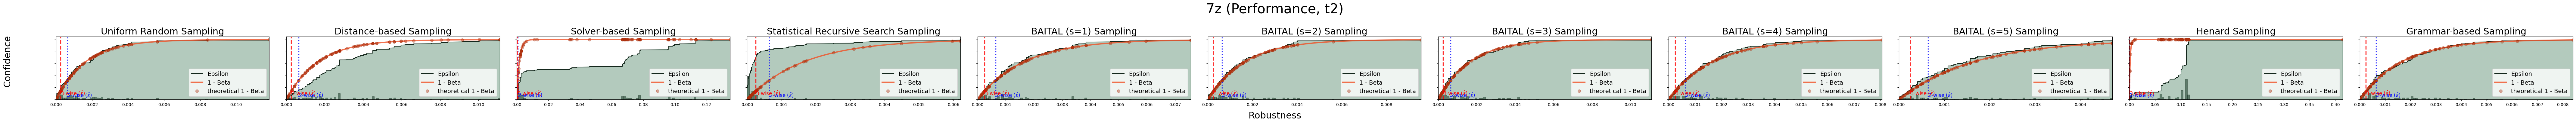

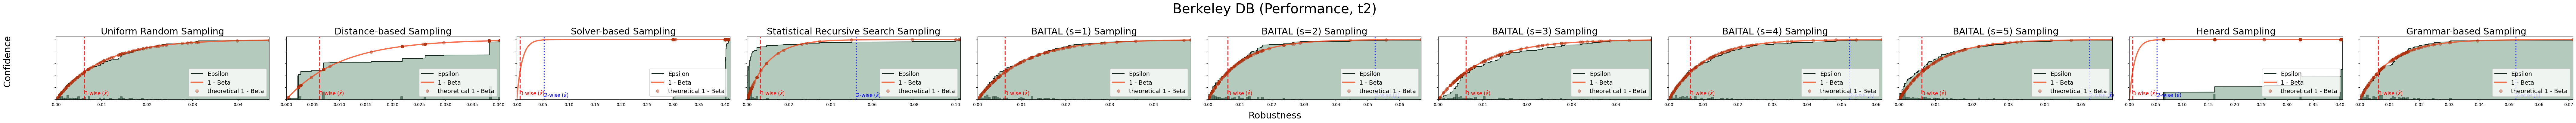

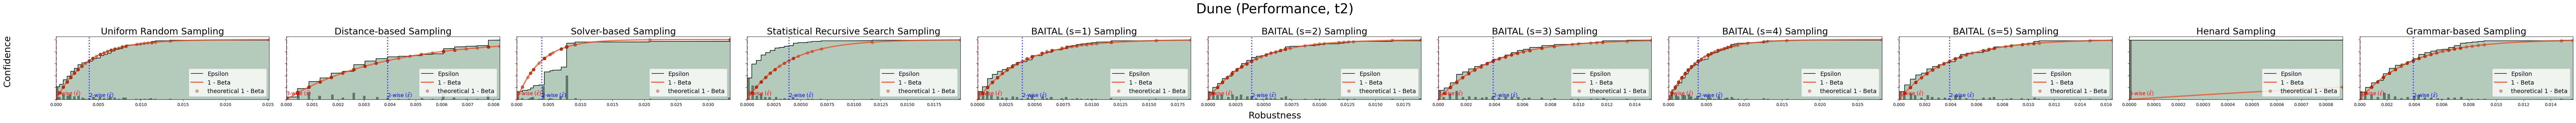

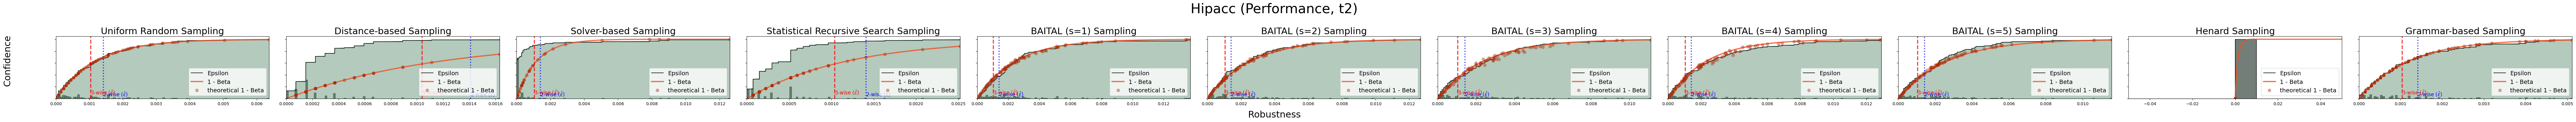

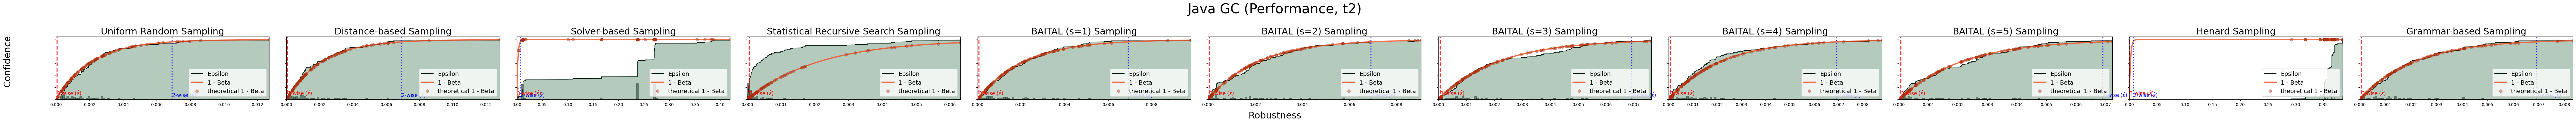

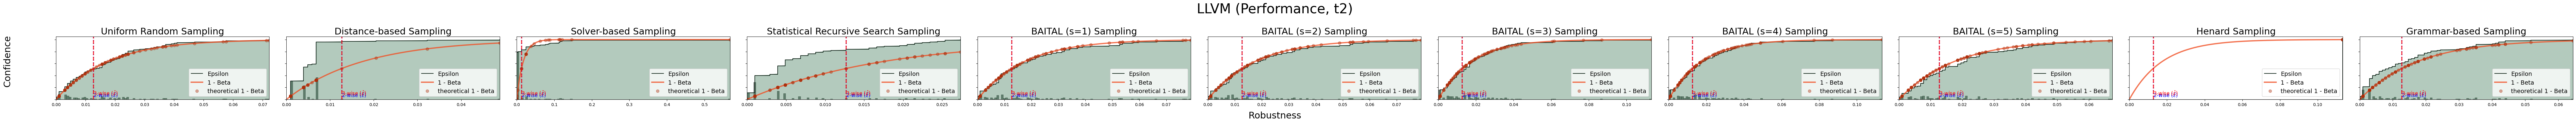

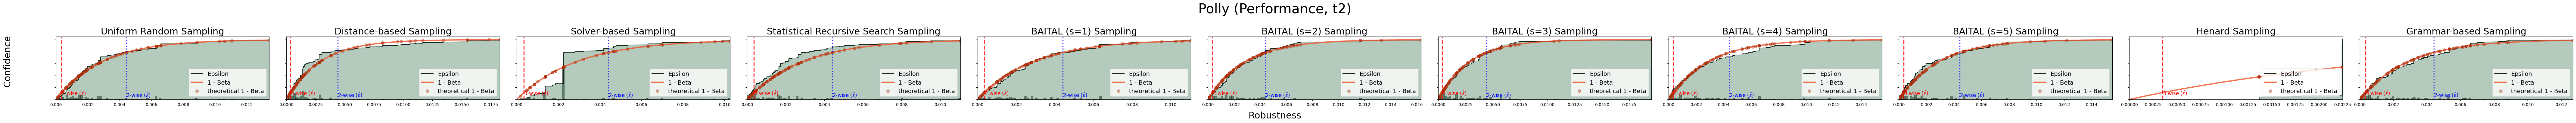

In [5]:
# Produce the plots for RQ 1

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}

# Data for the confidence discrepancy $\eta$ plot
confidence_difference_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Confidence Difference': []
}

# Data for the confidence plot
confidence_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Posterior Confidence': [],
    'Prior Confidence': []
}

# Define the steps for the curves in the confidence and confidence discrepancy plots
area_steps = [s / 1000 for s in range(0, 150, 1)]

# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data

# Final figure for the paper including all case studies in a single figure (only the line plots for the differences between posterior and prior 1-beta values)
fig_paper, axes_paper = plt.subplots(len(cs_information), 1, figsize=(12, 4 * len(cs_information)), sharex=True)

for row_paper, (cs, nfp, diagram_title) in zip(range(len(cs_information)), cs_information):
    fig, axes = plt.subplots(1, 1 * len(sampling_strategies), figsize=(8 * len(sampling_strategies), 4), sharey=True)
    cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
    cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

    for (strategy, separator, color, strategy_title), row_i in zip(sampling_strategies, range(0, len(sampling_strategies))):

        epsilon_values_strategy = []
        inv_beta_values_strategy = []

        for i in range(1, number_of_sample_sets + 1):
            cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_rq1 + '.csv', sep=separator)
            cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
            cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

            epsilon_values_strategy.append(estimate_epsilon(cs_measurements, cs_sample_points.max()))
            inv_beta_values_strategy.append(1 - calculate_prior_beta(epsilon_values_strategy[-1], len(cs_sample_points)))

        number_of_samples = len(cs_sample_points)

        pot_epsilon_values = [i/10000 for i in range(0, 8000)]
        pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, number_of_samples) for epsilon in pot_epsilon_values]

        data_df = pd.DataFrame({'epsilon': epsilon_values_strategy, '1-beta': inv_beta_values_strategy})
        sorted_data_df = data_df.sort_values('epsilon')

        epsilon_values_strategy = sorted_data_df['epsilon'].to_numpy()
        inv_beta_values_strategy = sorted_data_df['1-beta'].to_numpy()

        ax = axes[row_i]
        ax.axis(xmin=0.0, xmax=epsilon_values_strategy.max())
        y_bottom = 0.0
        y_top = 1.05
        ax.axis(ymin=y_bottom, ymax=y_top)

        sns.ecdfplot(epsilon_values_strategy, ax=ax, color='#15281d')

        ax.plot(pot_epsilon_values, pot_inv_beta_values, '#f15025', alpha=0.8, lw=3)
        ax.plot(epsilon_values_strategy, inv_beta_values_strategy, 'o', color='#ad2e0b', markersize=7, alpha=0.4, lw=2)
        ax.legend(['Epsilon', '1 - Beta', 'theoretical 1 - Beta'], fontsize=14, loc='lower right')
        ax.set_title(strategy_title + ' Sampling', fontsize=22)

        sns.histplot(x=epsilon_values_strategy, ax=ax, alpha=0.6, stat="probability", kde=False, bins=num_bins, color='#15281d')
    
        line1 = ax.lines[0]
        x1 = line1.get_xydata()[:,0]
        y1 = line1.get_xydata()[:,1]
        ax.fill_between(x1, y1, color='#417b5a', alpha=0.4)
        
        # Add t2 reference line
        try:
            cs_sample_points_df_t2 = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_twise_t2.csv', sep=';')
            cs_sample_points_df_t2 = pd.merge(cs_sample_points_df_t2, cs_measurements_df, on=list(cs_sample_points_df_t2.columns), how='inner')
            cs_sample_points_t2 = cs_sample_points_df_t2[nfp].to_numpy().flatten()
            epsilon_t2_wise = estimate_epsilon(cs_measurements, cs_sample_points_t2.max())
            if (epsilon_t2_wise < epsilon_values_strategy.max()):
                ax.axvline(epsilon_t2_wise, color='blue', linestyle='dotted', linewidth=2.5, alpha=0.8)
                ax.text(epsilon_t2_wise, y_bottom + 0.02, '2-wise ($\hat{\epsilon}$)', color='blue', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        except FileNotFoundError:
            print(f"t2 file not found for {cs}_{i}")
    
        # Add t3 reference line
        try:
            cs_sample_points_df_t3 = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_twise_t3.csv', sep=';')
            cs_sample_points_df_t3 = pd.merge(cs_sample_points_df_t3, cs_measurements_df, on=list(cs_sample_points_df_t3.columns), how='inner')
            cs_sample_points_t3 = cs_sample_points_df_t3[nfp].to_numpy().flatten()
            epsilon_t3_wise = estimate_epsilon(cs_measurements, cs_sample_points_t3.max())
            if (epsilon_t3_wise < epsilon_values_strategy.max()):
                ax.axvline(epsilon_t3_wise, color='red', linestyle='dashed', linewidth=2.5, alpha=0.8)
                ax.text(epsilon_t3_wise, y_bottom + 0.05, '3-wise ($\hat{\epsilon}$)', color='red', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        except FileNotFoundError:
            print(f"t3 file not found for {cs}_{i}")

        # Compute the plot to show the difference between posterior and prior 1-beta values
        posterior_epsilon_values[strategy] = ax.lines[0].get_xdata()[np.isfinite(ax.lines[0].get_xdata())]

        sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(posterior_epsilon_values[strategy])
        posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
        prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, number_of_samples) for area_step in area_steps])

        diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals

        # Add plot to the figure for the paper
        # axes_paper[row_paper].plot(posterior_epsilon_values[strategy], diff_inv_beta_values[strategy], '-', markersize=7, alpha=0.8, lw=2, color=color, label=strategy_title)
        axes_paper[row_paper].plot(area_steps, diff_inv_beta_vals, '-', markersize=7, alpha=0.8, lw=2, color=color, label=strategy_title) #  label='_Hidden')

        confidence_difference_data['Case Study'].extend([cs] * len(area_steps))
        confidence_difference_data['Sampling Strategy'].extend([strategy] * len(area_steps))
        confidence_difference_data['Robustness'].extend(area_steps)
        confidence_difference_data['Confidence Difference'].extend(diff_inv_beta_vals)

        confidence_data['Case Study'].extend([cs] * len(area_steps))
        confidence_data['Sampling Strategy'].extend([strategy] * len(area_steps))
        confidence_data['Robustness'].extend(area_steps)
        confidence_data['Posterior Confidence'].extend(posterior_inv_beta_vals)
        confidence_data['Prior Confidence'].extend(prior_inv_beta_vals)

# Plot the different plots for the paper in a raw, matplotlib version
    axes_paper[row_paper].axhline(0, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
    axes_paper[row_paper].legend(fontsize=14, loc='lower right')
    axes_paper[row_paper].axis(xmin=0.0, xmax=0.15)
    axes_paper[row_paper].set_title(cs, fontsize=20, loc='left')

    if (epsilon_t2_wise < 0.15):
        axes_paper[row_paper].axvline(epsilon_t2_wise, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
        axes_paper[row_paper].text(epsilon_t2_wise, y_bottom, '2-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

    if (epsilon_t3_wise < 0.15):
        axes_paper[row_paper].axvline(epsilon_t3_wise, color='black', linestyle='dashed', linewidth=2.5, alpha=0.8)
        axes_paper[row_paper].text(epsilon_t3_wise, y_bottom + 0.03, '3-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

    for ax in axes:
        ax.set_yticklabels([])
        ax.set_ylabel('')

    fig.suptitle(diagram_title, fontsize=32, y=0.98)
    fig.supxlabel('Robustness', fontsize=22)
    fig.supylabel('Confidence', fontsize=22)
    fig.subplots_adjust(top = 0.70, bottom=0.18, left=0.04, right=0.99, hspace=0.3, wspace=0.08)
    fig.savefig('results/' + cs  + '_robustness_distribution.pdf', format='pdf')
fig_paper.supxlabel('Robustness', fontsize=22)
fig_paper.supylabel('Confidence difference', fontsize=22)
fig_paper.subplots_adjust(top = 0.99, bottom=0.03, left=0.08, hspace=0.3, wspace=0.04)
fig_paper.savefig('results/allCaseStudies_confidence_differences.pdf', format='pdf')
plt.show()

# Store the data for the confidence and confidence discrepancy plots to plot them in tikz, pgfplots
pd.DataFrame(confidence_difference_data).to_csv('data/sampling/confidence_difference_data.csv', index=False)
pd.DataFrame(confidence_data).to_csv('data/sampling/confidence_data.csv', index=False)

In [7]:
# Produce the data for the plots for RQ 2

sampling_strategies = [
    ('random', ';', color_palette[0], 'Uniform Random'),
    ('divDistBased', ';', color_palette[1], 'Distance-based'),
    ('solverBased', ';', color_palette[2], 'Solver-based'),
    ('SRSSampling', ',', color_palette[3], 'Statistical Recursive Search'),
    ('baital_s1', ';', color_palette[4], 'BAITAL (s=1)'),
    ('baital_s2', ';', color_palette[5], 'BAITAL (s=2)'),
    ('baital_s3', ';', color_palette[6], 'BAITAL (s=3)'),
    ('baital_s4', ';', color_palette[7], 'BAITAL (s=4)'),
    ('baital_s5', ';', color_palette[8], 'BAITAL (s=5)'),
    ]

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}
area_aggregates = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Sample Set Size': [],
    'Area': []
}

area_steps = [s / 10000 for s in range(0, 10000, 1)]

# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data
for (cs, nfp, _) in cs_information:
    cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
    cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

    for (strategy, separator, color, _), row_i in zip(sampling_strategies, range(0, len(sampling_strategies))):
        epsilon_values_strategy = []
        inv_beta_values_strategy = []

        epsilon_beta_values_area = {
            'Repetition': [],
            'Sample Set Size': [],
            'Epsilon Value': [],
        }
        inv_beta_values_area = []

        for i in range(1, number_of_sample_sets + 1):
            cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_rq2 + '.csv', sep=separator)
            cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
            cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

            # Collect the data for the different sample set sizes (we made sure to collect the samples inside the sets in the order provided by the sampling strategy)
            for bound in range(len(cs_sample_points), 0, -10):
                epsilon_beta_values_area['Repetition'].append(i)
                epsilon_beta_values_area['Sample Set Size'].append(bound)
                tmp_epsilon = estimate_epsilon(cs_measurements, cs_sample_points[:bound].max())
                epsilon_beta_values_area['Epsilon Value'].append(tmp_epsilon)

            epsilon_values_strategy.append(estimate_epsilon(cs_measurements, cs_sample_points.max()))
            inv_beta_values_strategy.append(1 - calculate_prior_beta(epsilon_values_strategy[-1], len(cs_sample_points)))

        epsilon_beta_values_area_df = pd.DataFrame(epsilon_beta_values_area)

        number_of_samples = len(cs_sample_points)

        pot_epsilon_values = [i/10000 for i in range(0, 8000)]
        pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, number_of_samples) for epsilon in pot_epsilon_values]

        data_df = pd.DataFrame({'epsilon': epsilon_values_strategy, '1-beta': inv_beta_values_strategy})
        sorted_data_df = data_df.sort_values('epsilon')

        epsilon_values_strategy = sorted_data_df['epsilon'].to_numpy()
        inv_beta_values_strategy = sorted_data_df['1-beta'].to_numpy()

        for range_val in epsilon_beta_values_area_df['Sample Set Size'].drop_duplicates().sort_values(ascending=True):
            epsilon_vals = epsilon_beta_values_area_df[epsilon_beta_values_area_df['Sample Set Size'] == range_val]['Epsilon Value']
            sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(epsilon_vals)
            posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
            prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, range_val) for area_step in area_steps])

            diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals
            area_aggregates['Case Study'].append(cs)
            area_aggregates['Sampling Strategy'].append(strategy)
            area_aggregates['Sample Set Size'].append(range_val)
            area_aggregates['Area'].append(integrate.simpson(diff_inv_beta_vals, area_steps))

area_aggregates_df = pd.DataFrame(area_aggregates)
area_aggregates_df.to_csv('data/sampling/area_aggregation.csv', index=False)


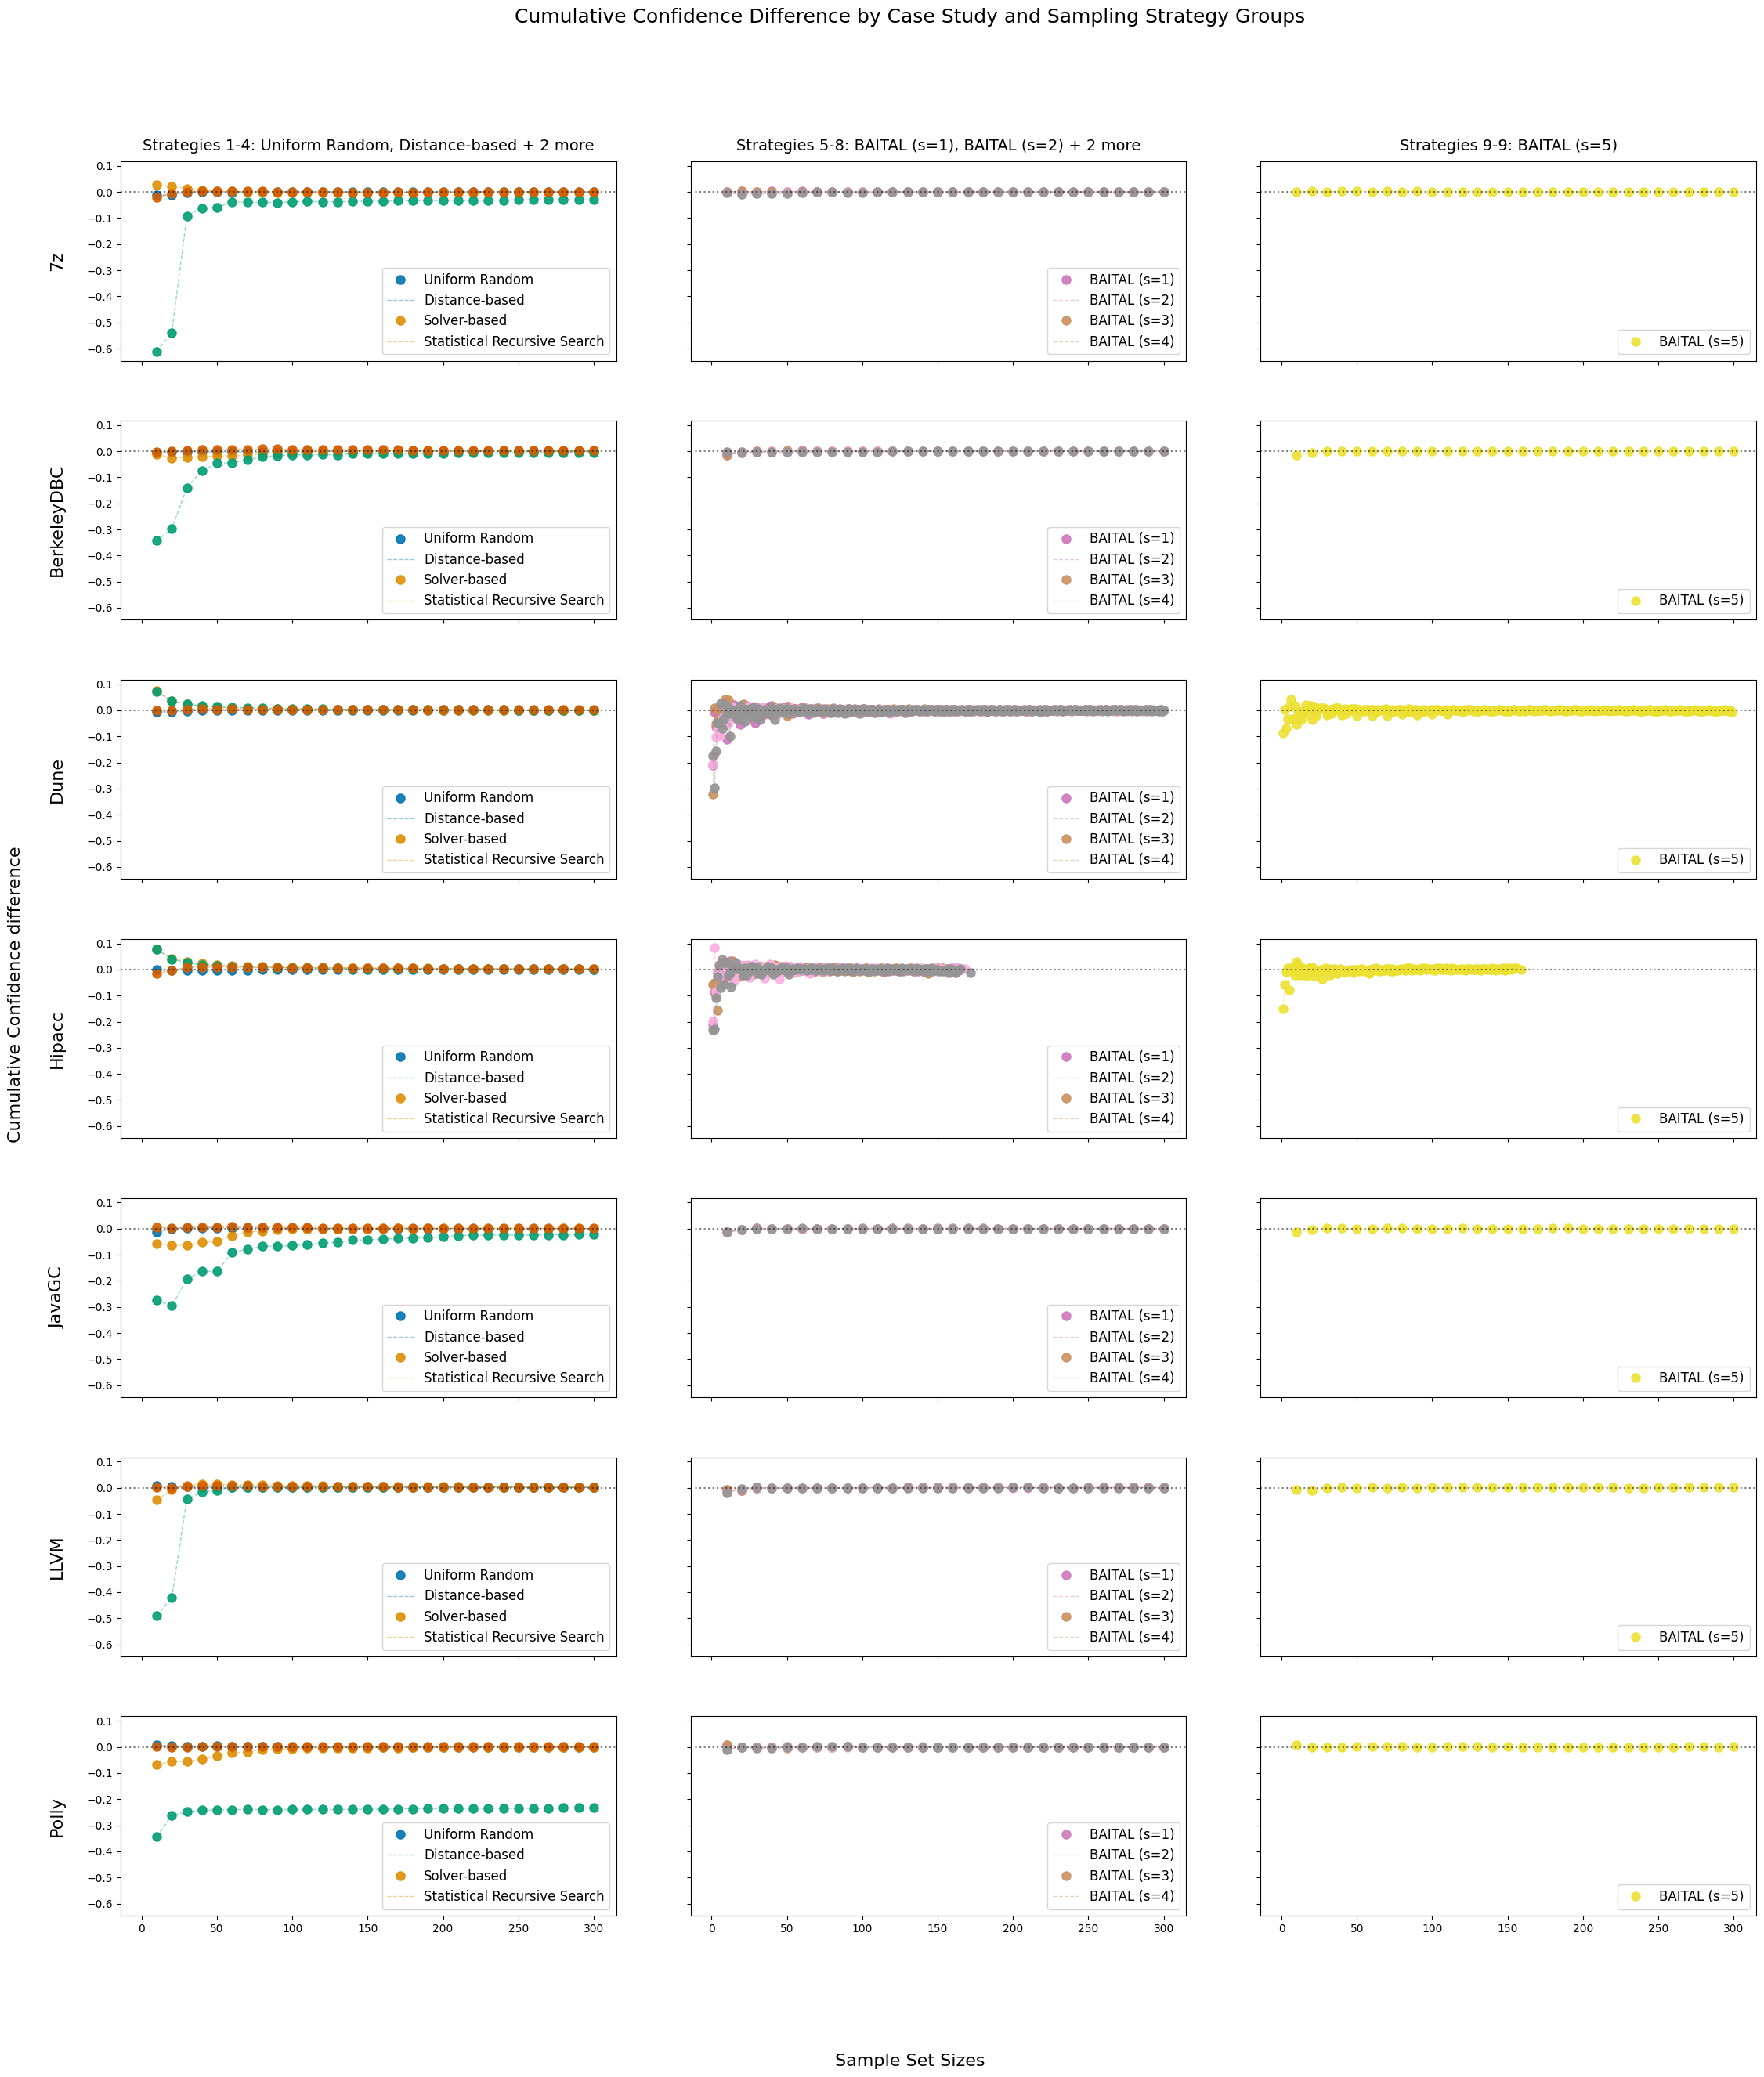

In [8]:
# Plot the integrated confidence discrepancy for the different sample set sizes
area_aggregates_df = pd.read_csv(root_path + 'area_aggregation.csv')

# Define how many strategies per subplot
strategies_per_subplot = 4
num_strategy_subplots = (len(sampling_strategies) + strategies_per_subplot - 1) // strategies_per_subplot  # Ceiling division

# Number of case studies
num_case_studies = area_aggregates_df['Case Study'].nunique()

# Create subplots: rows for case studies, columns for strategy groups
fig, axes = plt.subplots(num_case_studies, num_strategy_subplots, 
                        figsize=(8 * num_strategy_subplots, 4 * num_case_studies), 
                        sharey=True, sharex=True)

# Ensure axes is always 2D
if num_case_studies == 1:
    axes = axes.reshape(1, -1)
if num_strategy_subplots == 1:
    axes = axes.reshape(-1, 1)

# Initialize all axes as off
for ax_row in axes:
    for ax in ax_row:
        ax.set_axis_off()

for case_study_idx, case_study in enumerate(area_aggregates_df['Case Study'].unique()):
    case_study_df = area_aggregates_df[area_aggregates_df['Case Study'] == case_study]
    
    # Create subplots for different strategy groups
    for subplot_idx in range(num_strategy_subplots):
        ax = axes[case_study_idx, subplot_idx]
        ax.set_axis_on()
        
        # Get the strategies for this subplot
        start_idx = subplot_idx * strategies_per_subplot
        end_idx = min(start_idx + strategies_per_subplot, len(sampling_strategies))
        subplot_strategies = sampling_strategies[start_idx:end_idx]
        
        # Plot the strategies for this subplot
        for strategy, _, color, _ in subplot_strategies:
            strategy_df = case_study_df[case_study_df['Sampling Strategy'] == strategy]
            if not strategy_df.empty:
                ax.plot(strategy_df['Sample Set Size'], strategy_df['Area'], 'o', markersize=8, alpha=0.9, color=color)
                ax.plot(strategy_df['Sample Set Size'], strategy_df['Area'], markersize=5, alpha=0.4, lw=1, linestyle='--', color=color)
        
        ax.axhline(0, color='black', linestyle='dotted', linewidth=1.5, alpha=0.5)
        ax.legend([sampling_title for _, _, _, sampling_title in subplot_strategies], fontsize=12, loc='lower right')
        
        # Set title only for the first column
        if subplot_idx == 0:
            ax.set_ylabel(case_study, fontsize=16, rotation=90, labelpad=20)
        
        # Set column titles only for the first row
        if case_study_idx == 0:
            strategy_names = [title for _, _, _, title in subplot_strategies]
            ax.set_title(f"Strategies {start_idx+1}-{end_idx}: {', '.join(strategy_names[:2])}" + 
                        (f" + {len(strategy_names)-2} more" if len(strategy_names) > 2 else ""), 
                        fontsize=14, pad=10)

fig.suptitle('Cumulative Confidence Difference by Case Study and Sampling Strategy Groups', fontsize=18, y=0.95)
fig.supxlabel('Sample Set Sizes', fontsize=16)
fig.supylabel('Cumulative Confidence difference', fontsize=16)
fig.subplots_adjust(top=0.88, bottom=0.08, left=0.08, right=0.95, hspace=0.3, wspace=0.15)

plt.show()

In [11]:
# Produce the data for the plots for Polly in the discussion

sample_size_suffix_discussion = "sampleSize_2100"

sampling_strategies = [
    ('solverBased', ';', color_palette[2], 'Solver-based'),
    ('SRSSampling', ',', color_palette[3], 'Statistical Recursive Search'),
    ]

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}
area_aggregates = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Sample Set Size': [],
    'Area': []
}

area_steps = [s / 10000 for s in range(0, 10000, 1)]

# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data
(cs, nfp, _) = cs_information[-1]
cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

for (strategy, separator, color, _), row_i in zip(sampling_strategies[:], range(0, len(sampling_strategies[:]))):
    epsilon_beta_values_area = {
        'Repetition': [],
        'Sample Set Size': [],
        'Epsilon Value': [],
    }

    for i in range(1, number_of_sample_sets + 1):
        cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_discussion + '.csv', sep=separator)
        cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
        cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

        for bound in range(len(cs_sample_points), 0, -10):
            epsilon_beta_values_area['Repetition'].append(i)
            epsilon_beta_values_area['Sample Set Size'].append(bound)
            tmp_epsilon = estimate_epsilon(cs_measurements, cs_sample_points[:bound].max())
            epsilon_beta_values_area['Epsilon Value'].append(tmp_epsilon)

    epsilon_beta_values_area_df = pd.DataFrame(epsilon_beta_values_area)

    for range_val in epsilon_beta_values_area_df['Sample Set Size'].drop_duplicates().sort_values(ascending=True):
        epsilon_vals = epsilon_beta_values_area_df[epsilon_beta_values_area_df['Sample Set Size'] == range_val]['Epsilon Value']
        sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(epsilon_vals)
        posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
        prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, range_val) for area_step in area_steps])

        diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals
        area_aggregates['Case Study'].append(cs)
        area_aggregates['Sampling Strategy'].append(strategy)
        area_aggregates['Sample Set Size'].append(range_val)
        area_aggregates['Area'].append(integrate.simpson(diff_inv_beta_vals, area_steps))

area_aggregates_df = pd.DataFrame(area_aggregates)
area_aggregates_df.to_csv('data/sampling/area_aggregation_polly_2100.csv', index=False)

<>:96: SyntaxWarning: invalid escape sequence '\h'
<>:96: SyntaxWarning: invalid escape sequence '\h'
/var/folders/hj/x93rqrkn5zx8g7nx4gdjjp0r0000gn/T/ipykernel_38759/1892817865.py:96: SyntaxWarning: invalid escape sequence '\h'
  ax.text(epsilon_t_wise, y_bottom, 't-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')


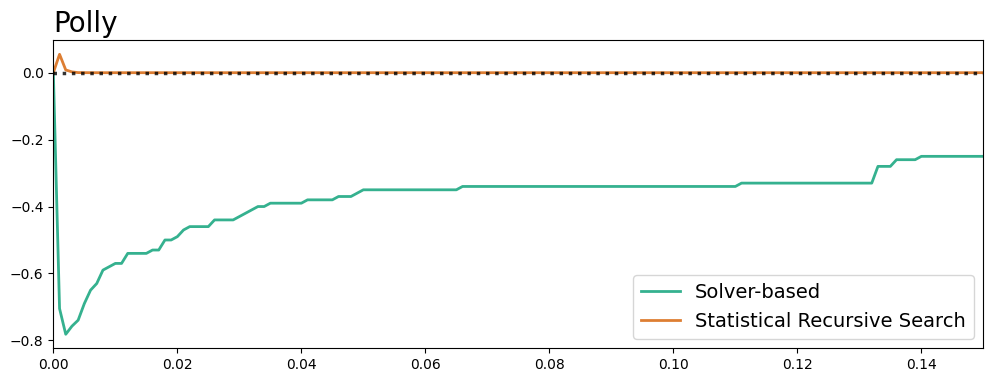

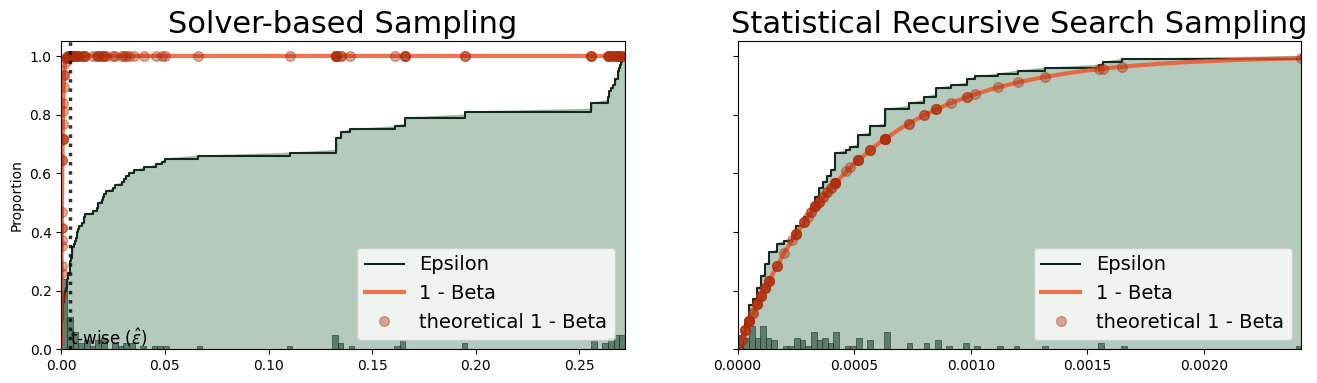

In [12]:
# Produce the plots for Discussion

# You can choose between the number of samples for which you want to look into the data

# lower bound for the number of samples
# discussion_bound = 15

# upper bound for the number of samples
discussion_bound = 2000

cs, nfp, diagram_title = cs_information[-1]  

discussion_sampling_strategies = sampling_strategies[-2:]

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}

confidence_difference_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Confidence Difference': []
}

confidence_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Posterior Confidence': [],
    'Prior Confidence': []
}

area_steps = [s / 1000 for s in range(0, 1000, 1)]
# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data

# Final figure for the paper including all case studies in a single figure (only the line plots for the differences between posterior and prior 1-beta values)
fig_paper, axes_paper = plt.subplots(1, 1, figsize=(12, 4))

fig, axes = plt.subplots(1, 1 * len(discussion_sampling_strategies), figsize=(8 * len(discussion_sampling_strategies), 4), sharey=True)
cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

for (strategy, separator, color, strategy_title), row_i in zip(discussion_sampling_strategies, range(0, len(discussion_sampling_strategies))):

    epsilon_values_strategy = []
    inv_beta_values_strategy = []

    for i in range(1, number_of_sample_sets + 1):
        cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_discussion + '.csv', sep=separator)
        cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
        cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

        epsilon_values_strategy.append(estimate_epsilon(cs_measurements, cs_sample_points[:discussion_bound].max()))
        inv_beta_values_strategy.append(1 - calculate_prior_beta(epsilon_values_strategy[-1], len(cs_sample_points[:discussion_bound])))

    number_of_samples = len(cs_sample_points[:discussion_bound])

    pot_epsilon_values = [i/10000 for i in range(0, 8000)]
    pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, number_of_samples) for epsilon in pot_epsilon_values]

    data_df = pd.DataFrame({'epsilon': epsilon_values_strategy, '1-beta': inv_beta_values_strategy})
    sorted_data_df = data_df.sort_values('epsilon')

    epsilon_values_strategy = sorted_data_df['epsilon'].to_numpy()
    inv_beta_values_strategy = sorted_data_df['1-beta'].to_numpy()

    ax = axes[row_i]
    ax.axis(xmin=0.0, xmax=epsilon_values_strategy.max())
    y_bottom = 0.0
    y_top = 1.05
    ax.axis(ymin=y_bottom, ymax=y_top)

    sns.ecdfplot(epsilon_values_strategy, ax=ax, color='#15281d')

    ax.plot(pot_epsilon_values, pot_inv_beta_values, '#f15025', alpha=0.8, lw=3)
    ax.plot(epsilon_values_strategy, inv_beta_values_strategy, 'o', color='#ad2e0b', markersize=7, alpha=0.4, lw=2)
    ax.legend(['Epsilon', '1 - Beta', 'theoretical 1 - Beta'], fontsize=14, loc='lower right')
    ax.set_title(strategy_title + ' Sampling', fontsize=22)

    sns.histplot(x=epsilon_values_strategy, ax=ax, alpha=0.6, stat="probability", kde=False, bins=num_bins, color='#15281d')

    line1 = ax.lines[0]
    x1 = line1.get_xydata()[:,0]
    y1 = line1.get_xydata()[:,1]
    ax.fill_between(x1, y1, color='#417b5a', alpha=0.4)

    cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + 'twise' + '_' + sample_size_suffix_rq1 + '.csv', sep=';')
    cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
    cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()
    epsilon_t_wise = estimate_epsilon(cs_measurements, cs_sample_points.max())
    if (epsilon_t_wise < epsilon_values_strategy.max()):
        ax.axvline(epsilon_t_wise, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
        ax.text(epsilon_t_wise, y_bottom, 't-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left') 

    # Compute the plot to show the difference between posterior and prior 1-beta values
    posterior_epsilon_values[strategy] = ax.lines[0].get_xdata()[np.isfinite(ax.lines[0].get_xdata())]

    sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(posterior_epsilon_values[strategy])
    posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
    prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, number_of_samples) for area_step in area_steps])

    diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals

    # Add plot to the figure for the paper
    axes_paper.plot(area_steps, diff_inv_beta_vals, '-', markersize=7, alpha=0.8, lw=2, color=color, label=strategy_title) #  label='_Hidden')

    confidence_difference_data['Case Study'].extend([cs] * len(area_steps))
    confidence_difference_data['Sampling Strategy'].extend([strategy] * len(area_steps))
    confidence_difference_data['Robustness'].extend(area_steps)
    confidence_difference_data['Confidence Difference'].extend(diff_inv_beta_vals)

    confidence_data['Case Study'].extend([cs] * len(area_steps))
    confidence_data['Sampling Strategy'].extend([strategy] * len(area_steps))
    confidence_data['Robustness'].extend(area_steps)
    confidence_data['Posterior Confidence'].extend(posterior_inv_beta_vals)
    confidence_data['Prior Confidence'].extend(prior_inv_beta_vals)

axes_paper.axhline(0, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
axes_paper.legend(fontsize=14, loc='lower right')
axes_paper.axis(xmin=0.0, xmax=0.15)
axes_paper.set_title(cs, fontsize=20, loc='left')

pd.DataFrame(confidence_difference_data).to_csv('data/sampling/confidence_difference_data_discussion_2000.csv', index=False)
pd.DataFrame(confidence_data).to_csv('data/sampling/confidence_data_discussion_2000.csv', index=False)

In [13]:
# Produce example data with different N for epsilon - beta relation

epsilon_beta_values = {
    'Sample Set Size': [],
    'Epsilon Value': [],
    '1 - Beta': []
}

for i in [15, 100, 250, 500, 1000, 2000]:
    epsilon_values = [i/10000 for i in range(0, 1000)]
    inv_beta_values = [1 - calculate_prior_beta(epsilon, i) for epsilon in epsilon_values]

    epsilon_beta_values['Sample Set Size'].extend([i] * len(epsilon_values))
    epsilon_beta_values['Epsilon Value'].extend(epsilon_values)
    epsilon_beta_values['1 - Beta'].extend(inv_beta_values)

epsilon_beta_values_df = pd.DataFrame(epsilon_beta_values)
epsilon_beta_values_df.to_csv('data/sampling/prior_epsilon_beta_values.csv', index=False)